In [1]:
import tskit
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D


def simplify_with_recombination(ts, flag_recomb=False, keep_nodes=None):
    """Simplifies a tree sequence while keeping recombination nodes

    Removes unary nodes that are not recombination nodes. Does not remove non-genetic ancestors.
    Edges intervals are not updated. This differs from how tskit's TreeSequence.simplify() works.

    Parameters
    ----------
    ts : tskit.TreeSequence
    flag_recomb (optional) : bool
        Whether to add msprime node flags. Default is False.
    keep_nodes (optional) : list
        List of node IDs that should be kept. Default is None, so empty list.

    Returns
    -------
    ts_sim : tskit.TreeSequence
        Simplified tree sequence
    maps_sim : numpy.ndarray
        Mapping for nodes in the simplified tree sequence versus the original
    """

    if keep_nodes == None:
        keep_nodes = []

    uniq_child_parent = np.unique(np.column_stack((ts.edges_child, ts.edges_parent)), axis=0)
    child_node, parents_count = np.unique(uniq_child_parent[:, 0], return_counts=True) #For each child, count how many parents it has.
    parent_node, children_count = np.unique(uniq_child_parent[:, 1], return_counts=True) #For each child, count how many parents it has.
    multiple_parents = child_node[parents_count > 1] #Find children who have more than 1 parent. 
    recomb_nodes = ts.edges_parent[np.isin(ts.edges_child, multiple_parents)] #Find the parent nodes of the children with multiple parents. 
    
    if flag_recomb:
        ts_tables = ts.dump_tables()
        node_table = ts_tables.nodes
        flags = node_table.flags
        flags[recomb_nodes] = 131072 #msprime.NODE_IS_RE_EVENT
        node_table.flags = flags
        ts_tables.sort() 
        ts = ts_tables.tree_sequence()
    
    keep_nodes = np.unique(np.concatenate((keep_nodes, recomb_nodes)))
    potentially_uninformative = np.intersect1d(child_node[np.where(parents_count!=0)[0]], parent_node[np.where(children_count==1)[0]])
    truly_uninformative = np.delete(potentially_uninformative, np.where(np.isin(potentially_uninformative, keep_nodes)))
    all_nodes = np.array(range(ts.num_nodes))
    important = np.delete(all_nodes, np.where(np.isin(all_nodes, truly_uninformative)))
    ts_sim, maps_sim = ts.simplify(samples=important, map_nodes=True, keep_input_roots=False, keep_unary=False, update_sample_flags=False)
    return ts_sim, maps_sim

In [2]:
ts = tskit.load("continuous_space_ten_samples.trees")

## Wohns et al. 2022 - Averaging Up (Midpoint)

This method works best with the standard `simplify()` as recombination nodes lead to artifacts in estimates. Starting at the tips, each parent is set to the average location of it's children.

In [3]:
def calc_midpoint_node_locations(ts, weighted=True):
    """Estimates node locations using averaging-up method

    Parent node location is the average of its children, potentially weighted by the length of edges
    to each child.

    Parameters
    ----------
    ts : tskit.TreeSequence
        Succinct tree sequence
    weighted : bool
        Whether to weight by the edge length. Default is True.

    Returns
    -------
    node_locations : dict
        Key is node ID and value is the coordinates as a list
    """
        
    node_locations = {}
    for sample in ts.samples():
        node_locations[sample] = ts.individual(ts.node(sample).individual).location
    
    node_times = {}
    for node in ts.nodes():
        node_times[node.id] = node.time
        
    for node in ts.nodes(order="timeasc"):
        if not node.is_sample():
            children = ts.tables.edges.child[np.where(ts.tables.edges.parent == node.id)]
            if len(children) > 1:
                locations = [[dimension] for dimension in node_locations[children[0]]]
                for child in children[1:]:
                    for dimension, location in enumerate(node_locations[child]):
                        locations[dimension].append(location)
                weights = [1 for child in children]
                if weighted:
                    weights =  [ 1.0/(node_times[node.id] - node_times[child]) for child in children ]
                    node_times[node.id] -= 1.0/sum(weights)
                averaged_locations = []
                for dimension in locations:
                    averaged_locations.append(np.average(dimension, weights = weights))
                node_locations[node.id] = np.array(averaged_locations)
            elif len(children) == 1:
                node_locations[node.id] = node_locations[children[0]]
            else:
                raise RuntimeError("Non-sample node doesn't have child.")
    return node_locations

ts_simple = ts.simplify()
locations = calc_midpoint_node_locations(ts_simple, weighted=False)

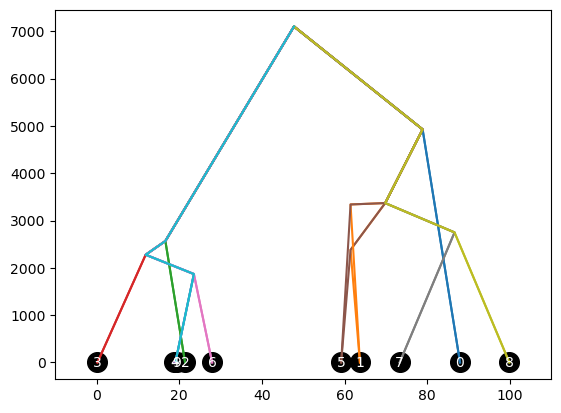

In [4]:
for tree in ts_simple.trees():

    for sample in ts_simple.samples():
    
        node = sample
        
        x_positions = [locations.get(node)[0]]
        y_positions = [locations.get(node)[1]]
        times = [tree.time(node)]
    
        node = tree.parent(node)
        while node != -1:
            x_positions.append(locations.get(node)[0])
            y_positions.append(locations.get(node)[1])
            times.append(tree.time(node))
            node = tree.parent(node)
    
        plt.plot(x_positions, times)
        
        
for sample in ts_simple.samples():
    plt.scatter(locations[sample][0], ts_simple.node(sample).time, s=200, color="black")
    plt.annotate(sample, (locations[sample][0], ts_simple.node(sample).time), ha="center", va="center", color="white")

plt.xlim(-10, 110)
plt.show()

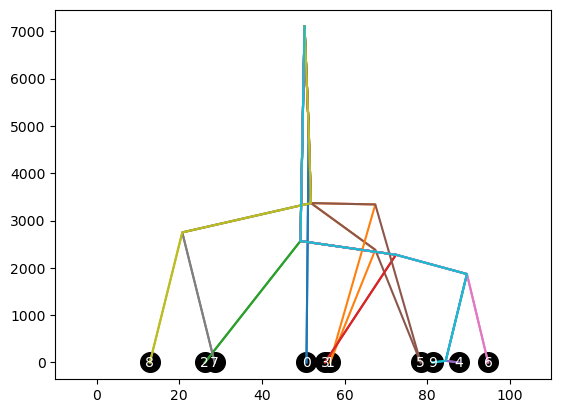

In [5]:
for tree in ts_simple.trees():

    for sample in ts_simple.samples():
    
        node = sample
        
        x_positions = [locations.get(node)[0]]
        y_positions = [locations.get(node)[1]]
        times = [tree.time(node)]
    
        node = tree.parent(node)
        while node != -1:
            x_positions.append(locations.get(node)[0])
            y_positions.append(locations.get(node)[1])
            times.append(tree.time(node))
            node = tree.parent(node)
    
        plt.plot(y_positions, times)
        
        
for sample in ts_simple.samples():
    plt.scatter(locations[sample][1], ts_simple.node(sample).time, s=200, color="black")
    plt.annotate(sample, (locations[sample][1], ts_simple.node(sample).time), ha="center", va="center", color="white")

plt.xlim(-10, 110)
plt.show()

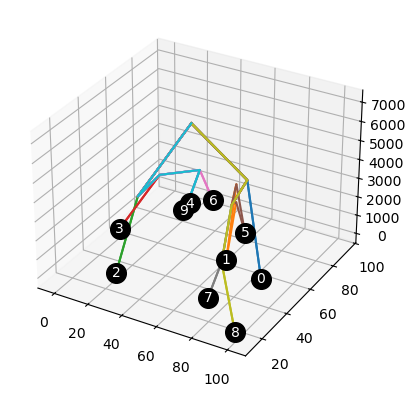

In [13]:
fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")

for tree in ts_simple.trees():

    for sample in ts_simple.samples():
    
        node = sample
        
        x_positions = [locations.get(node)[0]]
        y_positions = [locations.get(node)[1]]
        times = [tree.time(node)]
    
        node = tree.parent(node)
        while node != -1:
            x_positions.append(locations.get(node)[0])
            y_positions.append(locations.get(node)[1])
            times.append(tree.time(node))
            node = tree.parent(node)
    
        ax.plot(x_positions, y_positions, times)
        
        
for sample in ts_simple.samples():
    ax.scatter(locations[sample][0], locations[sample][1], 0, s=200, color="black")
    ax.text(locations[sample][0], locations[sample][1], 0, sample, zorder=20, ha="center", va="center", color="white")

plt.xlim(-10, 110)
plt.show()

In [78]:
ts_final, maps_final = simplify_with_recombination(ts, flag_recomb=True)
print(ts_final.draw_text())

9999.00┊       31            ┊       31            ┊       31            ┊       31            ┊       31            ┊  
       ┊        ┃            ┊        ┃            ┊        ┃            ┊        ┃            ┊        ┃            ┊  
7102.00┊       30            ┊       30            ┊       30            ┊       30            ┊       30            ┊  
       ┊   ┏━━━━┻━━━━┓       ┊   ┏━━━━┻━━━━┓       ┊   ┏━━━━┻━━━━┓       ┊   ┏━━━━┻━━━━┓       ┊   ┏━━━━┻━━━━┓       ┊  
5393.00┊  29         ┃       ┊  29         ┃       ┊  29         ┃       ┊  29         ┃       ┊  29         ┃       ┊  
       ┊   ┃         ┃       ┊   ┃         ┃       ┊   ┃         ┃       ┊   ┃         ┃       ┊   ┃         ┃       ┊  
5381.00┊  27         ┃       ┊  28         ┃       ┊  28         ┃       ┊  28         ┃       ┊  28         ┃       ┊  
       ┊   ┃         ┃       ┊   ┃         ┃       ┊   ┃         ┃       ┊   ┃         ┃       ┊   ┃         ┃       ┊  
4926.00┊  26         ┃       ┊  